In [64]:
# This notebook is for internal Apps Ops to quickly build simple models for v5 Orca
# Uses a simplified assumptions for most tools
# Single best estimator for each base model visnir and exnir
# Uses existing pptoolbox functions as much as possible

In [65]:
# import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import cross_val_predict, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder

from pptoolbox.platform.preprocessing import preprocess_v2
from pptoolbox.platform.automl_v4 import AutoML_v4
from pptoolbox.platform.automl_v4.pipelines import META_CLASSIFIER_PIPELINES, META_REGRESSION_PIPELINES

import glob
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt

# Helper Utils

In [66]:
# Dumping meta utils here. 
# Algorithm design still undergoing testing. not yet stable for pptoolbox?
import warnings
from typing import Literal, Optional
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import BaseCrossValidator, cross_val_predict


AUTOML_MODE_OPTIONS = ["classify", "profile"]

def create_meta_datasets_splits(
    estimators: list[list[Pipeline]],
    datasets: list[pd.DataFrame],
    y: pd.Series,
    groups: np.ndarray,
    outer_cv: BaseCrossValidator,
    inner_cv: BaseCrossValidator,
    mode: Literal[AUTOML_MODE_OPTIONS] = "classify",
) -> tuple[pd.DataFrame, pd.Series, np.ndarray]:
    """
    Custom pre-processing for meta-model cross validation flow
    This flow assumes we maintain the same split indexes across all hyperparams to be tested.
    Because of this, we can pre-calculate the features being input to meta-model
    Instead of re-fitting the same estimator at each fold
    """
    if mode not in AUTOML_MODE_OPTIONS:
        raise ValueError(f"Unexpected mode: {mode}. Expected {AUTOML_MODE_OPTIONS}")
    if len(datasets) == 1:
        raise ValueError(
            "This is meant for data fusion. Check your input is a List of pandas.DataFrame"
        )

    for X in datasets[1:]:
        if len(X) != len(datasets[0]):
            raise IndexError(
                f"Lengths of input datasets do not match ({datasets[0].shape[0]}), ({X.shape[0]})"
            )

    for i, estimator_list in enumerate(estimators):
        if type(estimator_list) != list:
            if type(estimator_list) == Pipeline:
                warnings.warn("Single estimator detected. Converting to list")
                estimators[i] = [estimator_list]
            else:
                raise ValueError("estimators should be a list of lists of Pipelines")

    if len(datasets) != len(estimators):
        raise ValueError(
            "Length of datasets and estimators do not match. Check your inputs"
        )

    if mode == "classify":
        n_classes = len(np.unique(y))
    else:
        n_classes = 1

    n = len(datasets[0])
    m_list = [0] + [len(estimator_list) for estimator_list in estimators]
    m = sum(m_list) * n_classes
    k = outer_cv.get_n_splits()

    new_indices = np.concatenate([datasets[0].index] * k)
    meta_X = np.zeros((n * k, m))
    meta_y = pd.Series(np.concatenate([y] * k), index=new_indices)
    splits_idx = np.zeros((n * k, 2))

    for fold_idx, (train_idx, test_idx) in enumerate(
        outer_cv.split(datasets[0], y, groups=groups)
    ):
        y_train = y.iloc[train_idx]
        splits_idx[n * fold_idx : n * (fold_idx + 1), 0] = fold_idx
        splits_idx[test_idx + (n * fold_idx), 1] = 1

        for i in range(len(datasets)):
            X = datasets[i]
            for j, estimator in enumerate(estimators[i]):
                X_train = X.iloc[train_idx]
                X_test = X.iloc[test_idx]

                if mode == "classify":
                    # Classification Flow
                    preds_train = cross_val_predict(
                        estimator,
                        X_train,
                        y_train,
                        groups=X_train.index,
                        cv=inner_cv,
                        method="predict_proba",
                    )
                    estimator.fit(X_train, y_train)
                    preds_test = estimator.predict_proba(X_test)
                else:
                    # Regression Flow
                    preds_train = cross_val_predict(
                        estimator,
                        X_train,
                        y_train,
                        groups=X_train.index,
                        cv=inner_cv,
                        method="predict",
                    )
                    estimator.fit(X_train, y_train)
                    preds_test = estimator.predict(X_test)

                meta_X[
                    train_idx + n * fold_idx,
                    n_classes * (j + m_list[i]) : n_classes * (j + 1 + m_list[i]),
                ] = preds_train.reshape(X_train.shape[0], n_classes)
                meta_X[
                    test_idx + n * fold_idx,
                    n_classes * (j + m_list[i]) : n_classes * (j + 1 + m_list[i]),
                ] = preds_test.reshape(X_test.shape[0], n_classes)

    meta_X = pd.DataFrame(meta_X, index=new_indices)

    return meta_X, meta_y, splits_idx


class CustomMetaSplitter(BaseCrossValidator):
    def __init__(self, split_idx: np.ndarray):
        self.splits = split_idx
        self.n_splits = len(np.unique(split_idx[:, 0]))

    def get_n_splits(
        self, X: Optional = None, y: Optional = None, groups: Optional = None
    ) -> int:
        return self.n_splits

    def split(self, X: Optional = None, y: Optional = None, groups: Optional = None):
        for i in range(self.n_splits):
            train_idx = np.where((self.splits[:, 0] == i) & (self.splits[:, 1] == 0))[0]
            test_idx = np.where((self.splits[:, 0] == i) & (self.splits[:, 1] == 1))[0]
            yield train_idx, test_idx



## trainer configs

In [67]:
def initialise_trainer(task_type ='classify', log=False, experiment_name='', mlflow_uri=None, *args, **kwargs):
    trainer = AutoML_v4(task_type = task_type, log = log, *args, **kwargs) # !updated exploration runs
    if log == True:
        trainer.set_log_config(
            experiment_name = f"{experiment_name}",
            mlflow_uri = mlflow_uri
        )
    return trainer

In [68]:
def generate_metafeatures_classify(datasets, estimators, y, cv = StratifiedGroupKFold(n_splits=3)):
    n_classes = len(np.unique(y))
    for i, estimator_list in enumerate(estimators):
        if type(estimator_list) != list:
            if type(estimator_list) == Pipeline:
                # warnings.warn("Single estimator detected. Converting to list")
                estimators[i] = [estimator_list]
            else:
                raise ValueError("estimators should be a list of lists of Pipelines")
    n = len(datasets[0])
    m_list = [0] + [len(estimator_list) for estimator_list in estimators]
    m = sum(m_list) * n_classes

    X_meta = np.zeros([n,m])
    for i in range(len(datasets)):
        X = datasets[i]
        for j, estimator in enumerate(estimators[i]):
            y_preds = cross_val_predict(estimator, X, y, groups=X.index, cv=cv, method='predict_proba')

            X_meta[
                :,
                n_classes * (j + m_list[i]) : n_classes * (j + 1 + m_list[i]),
            ] = y_preds.reshape(n, n_classes)
            pass

    return X_meta


In [69]:
"""Combined file simulating platform utils file."""
import pandas as pd
import numpy as np

import os
import pickle as pkl
from typing import Annotated, List, Tuple, Optional

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from pptoolbox.platform.automl_v4 import cross_group_predict
from pptoolbox.platform.automl_v4 import AutoML_v4

# Dump to file
def model_dump_classify(trainer: AutoML_v4, estimator, encoder: LabelEncoder, X: pd.DataFrame, encoded_y: pd.Series, output_dir: str, suffix: str=""):
    # Explicitly separated trainer and model because of the meta_model refit required

    # Dump model
    pkl.dump(
        estimator, 
        open(os.path.join(output_dir, f"origin_model_prediction{suffix}.pkl"), "wb")
    )

    # Dump trainer
    pkl.dump(
        trainer, 
        open(os.path.join(output_dir, f"trainer{suffix}.pkl"), "wb")
    )

    # Calculate CV confusion matrix
    cnfm = generate_classify_confusionmatrix(estimator, X, encoded_y, encoder)
    cnfm.to_csv(os.path.join(output_dir, f"confusion_matrix{suffix}.csv"))

    # Get CV metrics from AutoML trainer
    model_summary = generate_classify_metrics(trainer, name=0)
    model_summary.to_csv(os.path.join(output_dir, f"metrics{suffix}.csv"))
    return None

# Calculate CV confusion matrix
def generate_classify_confusionmatrix(estimator, X, encoded_y, encoder):
    grouped_y = encoded_y.groupby(encoded_y.index).apply(lambda x: x.iloc[0])

    metric_kfold = StratifiedGroupKFold(n_splits = 3)
    grouped_cv_pred = cross_group_predict(
        estimator,
        X,
        y = encoded_y,
        cv = metric_kfold, 
        groups = X.index
    )

    grouped_pred = pd.Series(
        encoder.inverse_transform(grouped_cv_pred), 
        index = grouped_y.index
    )

    grouped_true = pd.Series(
        encoder.inverse_transform(grouped_y),
        index = grouped_y.index
    )

    cnfm = pd.DataFrame(
        confusion_matrix(grouped_true, grouped_pred),
        index = encoder.classes_,
        columns = encoder.classes_
    )
    return cnfm

# Get CV metrics from AutoML trainer
def generate_classify_metrics(trainer, name:str='None'):
    best_trial = trainer.get_best_trial()
    model_summary = pd.Series(
        [
            trainer.get_pipeline_name(),
            best_trial["result"]["cv_results"]["test_balanced_accuracy"],
            best_trial["result"]["cv_results"]["test_f1_micro"],
            best_trial["result"]["cv_results"]["test_precision_micro"],
            best_trial["result"]["cv_results"]["test_recall_micro"]
        ], 
        index = [
            "model",
            "balanced_accuracy",
            "f1_score",
            "precision",
            "recall"
        ], 
        name = name
    )
    return model_summary


## custom functions

In [70]:
# adapted function to generate classify preds
def generate_classify_preds(estimator, X, encoded_y, encoder):
    grouped_y = encoded_y.groupby(encoded_y.index).apply(lambda x: x.iloc[0])

    metric_kfold = StratifiedGroupKFold(n_splits = 3)
    grouped_cv_pred = cross_group_predict(
        estimator,
        X,
        y = encoded_y,
        cv = metric_kfold, 
        groups = X.index
    )

    grouped_pred = pd.Series(
        encoder.inverse_transform(grouped_cv_pred), 
        index = grouped_y.index
    )

    grouped_true = pd.Series(
        encoder.inverse_transform(grouped_y),
        index = grouped_y.index
    )

    bal_acc = balanced_accuracy_score(grouped_true, grouped_pred)

    return grouped_pred, grouped_true, bal_acc

# Calculate blinds confusion matrix
def generate_blinds_confusionmatrix(estimator, X, encoded_y, encoder):
    
    grouped_X = X.groupby(X.index).mean()
    grouped_y = encoded_y.groupby(encoded_y.index).apply(lambda x: x.iloc[0])

    grouped_cv_enc = estimator.predict(grouped_X)

    grouped_pred = pd.Series(
        encoder.inverse_transform(grouped_cv_enc), 
        index = grouped_y.index
    )

    grouped_true = pd.Series(
        encoder.inverse_transform(grouped_y),
        index = grouped_y.index
    )

    cnfm = pd.DataFrame(
        confusion_matrix(grouped_true, grouped_pred),
        index = encoder.classes_,
        columns = encoder.classes_
    )

    bal_acc = balanced_accuracy_score(grouped_true, grouped_pred)

    return cnfm, grouped_pred, grouped_true, bal_acc

# Init

In [71]:
# Initialise configs
sql_response_file = Path("../data/raw/spectra_241127.csv")
labels_file = Path("../data/processed/label.csv")

input_df = pd.read_csv(sql_response_file) 
labels_df = pd.read_csv(labels_file)

N_SPLITS = 3
DEFAULT_CV = StratifiedGroupKFold(n_splits=N_SPLITS)

In [72]:
labels_df

,lot_id,lot_name,Flavor,Processing
0,84412,PNAL11-T,Huila,Roasted
1,84413,PNAL12-T,Huila,Roasted
2,84414,PNAL27-T,Huila,Roasted
3,84415,PNAL28-T,Huila,Roasted
4,84416,PNAL29-T,Huila,Roasted
...,...,...,...,...
73,84485,PNAL78-G,Tumaco,Unroasted
74,84486,PNAL79-G,Tumaco,Unroasted
75,84487,PNAL84-G,Tumaco,Unroasted
76,84488,PNAL85-G,Tumaco,Unroasted


## filter data

In [73]:
filter = [
    # 'Unroasted',
    'Roasted'
    ]
choice = filter[0]
labels_df = labels_df[labels_df['Processing']==choice]
labels_df.shape

(39, 4)

## preprocess

In [74]:
labels_df = labels_df.set_index('lot_id').select_dtypes(include=['object']).reset_index()
labels_df_og = labels_df.copy(deep=True)
labels_df = labels_df.drop(columns=['lot_name','Processing'])

X_visnir, X_exnir, y, datatype = preprocess_v2(input_df, labels_df)

## train test split manual

In [75]:
train_set = [
    'PNAL11','PNAL12','PNAL27','PNAL28','PNAL29',
    'PNAL78','PNAL79','PNAL84','PNAL85','PNAL86'
    ]

pattern = '|'.join(map(re.escape, train_set))

test_labels = labels_df_og[labels_df_og['lot_name'].str.contains(pattern, case=False, na=False)]
test_index = test_labels.set_index('lot_id').index

display(test_labels)
print(test_index)

,lot_id,lot_name,Flavor,Processing
0,84412,PNAL11-T,Huila,Roasted
1,84413,PNAL12-T,Huila,Roasted
2,84414,PNAL27-T,Huila,Roasted
3,84415,PNAL28-T,Huila,Roasted
4,84416,PNAL29-T,Huila,Roasted
34,84465,PNAL78-T,Tumaco,Roasted
35,84466,PNAL79-T,Tumaco,Roasted
36,84467,PNAL84-T,Tumaco,Roasted
37,84468,PNAL85-T,Tumaco,Roasted
38,84469,PNAL86-T,Tumaco,Roasted


Int64Index([84412, 84413, 84414, 84415, 84416, 84465, 84466, 84467, 84468,
            84469],
           dtype='int64', name='lot_id')


In [76]:
X_visnir_test = X_visnir.loc[test_index]
X_visnir_train = X_visnir[~X_visnir.index.isin(test_index)]

X_exnir_test = X_exnir.loc[test_index]
X_exnir_train = X_exnir[~X_exnir.index.isin(test_index)]

y_test = y.loc[test_index]
y_train = y[~y.index.isin(test_index)]

labels_df_og_train = labels_df_og[labels_df_og['lot_id'].isin(y_train.index.tolist())]
labels_df_og_test = labels_df_og[labels_df_og['lot_id'].isin(y_test.index.tolist())]

print(X_exnir_train.shape, X_exnir_test.shape, 
      X_visnir_train.shape, X_visnir_test.shape, 
      y_train.shape, y_test.shape, 
      labels_df_og_train.shape, labels_df_og_test.shape)

(203, 89) (70, 89) (203, 191) (70, 191) (203, 1) (70, 1) (29, 4) (10, 4)


## select property

In [77]:
print (y.columns)
labels = list(y.columns[[0]])
print(f'\nselected for training: {labels}')

Index(['Flavor'], dtype='object')

selected for training: ['Flavor']


# full loop

In [78]:
y=y_train
X_visnir=X_visnir_train
X_exnir=X_exnir_train

In [79]:
for label in labels:

    output_dir = Path(f"../model/predictions_classify/{choice}_{label}")
    output_dir.mkdir(exist_ok=True, parents=True)

    print(label)
    input_y = y[label]

    encoder = LabelEncoder()
    encoded_y = pd.Series(encoder.fit_transform(input_y), index = input_y.index)
    
    pkl.dump(
        encoder, 
        open(os.path.join(output_dir, f"encoder_{label}.pkl"), "wb")
    )

    # Run visnir segment (Qmini)
    trainer = initialise_trainer(task_type='classify', log=False)
    trainer.fit(X_visnir, encoded_y, kfold=DEFAULT_CV)
    score_visnir = trainer.get_best_performance()
    best_visnir = trainer.get_pipeline()
    metrics_visnir = generate_classify_metrics(trainer, name='visnir')
    trainer_visnir = trainer
    base_visnir = [best_visnir] # Wrapped in list format for meta step

    # print(metrics_visnir)

    # Run exnir segment (Qneo)
    trainer = initialise_trainer(task_type='classify', log=False)
    trainer.fit(X_exnir, encoded_y, kfold=DEFAULT_CV)
    score_exnir = trainer.get_best_performance()
    best_exnir = trainer.get_pipeline()
    metrics_exnir = generate_classify_metrics(trainer, name='exnir')
    trainer_exnir = trainer
    base_exnir = [best_exnir] # Wrapped in list format for meta step

    # print(metrics_exnir)

    # Prepare dataset for metamodel segment
    datasets = [X_visnir, X_exnir]
    estimators = [base_visnir, base_exnir] 
    X_meta, y_meta, split_idx = create_meta_datasets_splits(
        estimators=estimators, 
        datasets=datasets, 
        y=encoded_y, 
        groups=X_visnir.index, 
        outer_cv=DEFAULT_CV, 
        inner_cv=DEFAULT_CV,
        mode='classify',
    )

    # Run metamodel segment
    cv_meta = CustomMetaSplitter(split_idx = split_idx)
    trainer = initialise_trainer(task_type='classify', log=False)
    trainer.fit(X_meta, y_meta, kfold=cv_meta, search_space=META_CLASSIFIER_PIPELINES, groups=X_meta.index)
    score_meta = trainer.get_best_performance()
    metrics_meta = generate_classify_metrics(trainer, name='meta')

    X_meta_final = generate_metafeatures_classify(datasets, estimators, y=encoded_y)
    X_meta_final = pd.DataFrame(X_meta_final, index=X_visnir.index)

    # Dump X_meta_final
    pkl.dump(
        X_meta_final, 
        open(os.path.join(output_dir, f"X_meta_final_{label}.pkl"), "wb")
    )

    best_meta = trainer.get_pipeline()
    best_meta.fit(X_meta_final, encoded_y)
    trainer_meta = trainer

    # print(metrics_meta)

    # Dump metrics to folder

    model_dump_classify(
        trainer=trainer_visnir, 
        estimator=best_visnir, 
        X=X_visnir,
        encoder=encoder, 
        encoded_y=encoded_y, 
        output_dir=output_dir, 
        suffix="_visnir",
    )

    model_dump_classify(
        trainer=trainer_exnir, 
        estimator=best_exnir, 
        X=X_exnir,
        encoder=encoder, 
        encoded_y=encoded_y, 
        output_dir=output_dir, 
        suffix="_exnir",
    )

    model_dump_classify(
        trainer=trainer_meta, 
        estimator=best_meta, 
        X=X_meta_final,
        encoder=encoder, 
        encoded_y=encoded_y, 
        output_dir=output_dir, 
        suffix="_meta",
    )
    
    print()

Flavor
100%|██████████| 200/200 [00:36<00:00,  5.44trial/s, best loss: 0.0]



## extract metrics, check mispred

In [80]:
y=y_train
X_visnir=X_visnir_train
X_exnir=X_exnir_train
labels_df_og=labels_df_og_train

[AutoML v4: SNV-Scaler-SVC, AutoML v4: GaussianNB, AutoML v4: Detrend-Scaler-SVC]
[1.0, 1.0, 1.0]


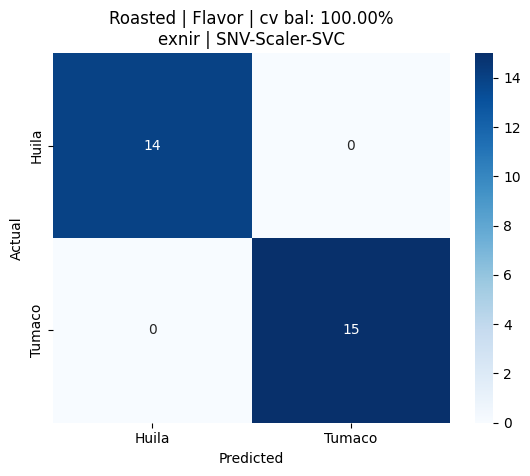

Mispredictions


,lot_name,Flavor,predicted


In [ ]:
for label in labels:

    output_dir = Path(f"../model/predictions_classify/{choice}_{label}")
    output_dir.mkdir(exist_ok=True, parents=True)

    input_y = y[label]

    encoder = pkl.load(open(output_dir/f"encoder_{label}.pkl", 'rb'))
    encoded_y = pd.Series(encoder.transform(input_y), index = input_y.index)

    list_of_pkl_files = glob.glob(f'../model/predictions_classify/{choice}_{label}/trainer_*.pkl')
    model_name = [re.search(r'_([^_]+)\.pkl$', filename).group(1) for filename in list_of_pkl_files]
    loaded_pkl = [pkl.load(open(file, 'rb')) for file in list_of_pkl_files]
    print(loaded_pkl)

    metrics = [generate_classify_metrics(loaded_pkl[i],model) for i,model in enumerate(loaded_pkl)]
    pipelines = [model.get_pipeline() for model in loaded_pkl]
        
    performances = [model.get_best_performance() for model in loaded_pkl]
    print(performances)
    best_performance = np.argmax(np.array(performances)) # argmax, Most positive bal acc wins
    
    best_model =  {'name':model_name[best_performance], **metrics[best_performance]}
    # best_model_output =  json.dumps(best_model, indent=4)

    X_meta_final = pkl.load(open(output_dir/f'X_meta_final_{label}.pkl', 'rb'))

    dataset_options = {
        'exnir': X_exnir,
        'visnir': X_visnir,
        'meta': X_meta_final, # meta dataset is generated inside training loop
    }

    prediction, truth, bal_acc = generate_classify_preds(
        pipelines[best_performance], 
        dataset_options[best_model['name']], 
        encoded_y, 
        encoder
        )

    cnfm = generate_classify_confusionmatrix(
        pipelines[best_performance], 
        dataset_options[best_model['name']], 
        encoded_y, 
        encoder
        )
    f, ax = plt.subplots()
    sns.heatmap(cnfm, annot=True, ax=ax, cmap="Blues")
    ax.set(title=f'{choice} | {label} | cv bal: {bal_acc*100:.2f}%\n{best_model["name"]} | {best_model["model"]}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.savefig(output_dir/f'confusion_matrix_best.png', bbox_inches='tight')
    plt.show()
    plt.close()
    
    print('Mispredictions')
    output_df = labels_df_og.sort_values('lot_id')[['lot_name',label]]
    output_df['predicted'] = prediction.values
    final_output = output_df[output_df[label]!=output_df['predicted']]
    display(final_output)

# predict on blinds

In [82]:
y=y_test
X_visnir=X_visnir_test
X_exnir=X_exnir_test
labels_df_og=labels_df_og_test

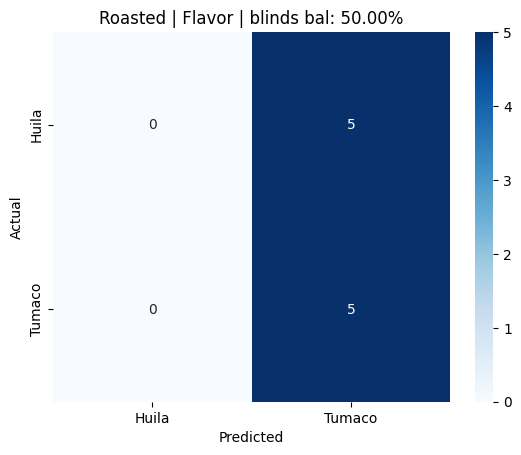

Mispredictions


,lot_name,Flavor,predicted
0,PNAL11-T,Huila,Tumaco
1,PNAL12-T,Huila,Tumaco
2,PNAL27-T,Huila,Tumaco
3,PNAL28-T,Huila,Tumaco
4,PNAL29-T,Huila,Tumaco


In [ ]:
for label in labels:

    output_dir = Path(f"../model/predictions_classify/{choice}_{label}")
    output_dir.mkdir(exist_ok=True, parents=True)

    input_y = y[label]

    encoder = pkl.load(open(output_dir/f"encoder_{label}.pkl", 'rb'))
    encoded_y = pd.Series(encoder.transform(input_y), index = input_y.index)

    list_of_pkl_files = glob.glob(f'../model/predictions_classify/{choice}_{label}/trainer_*.pkl')
    model_name = [re.search(r'_([^_]+)\.pkl$', filename).group(1) for filename in list_of_pkl_files]
    loaded_pkl = [pkl.load(open(file, 'rb')) for file in list_of_pkl_files]

    metrics = [generate_classify_metrics(loaded_pkl[i],model) for i,model in enumerate(loaded_pkl)]
    pipelines = [model.get_pipeline() for model in loaded_pkl]
    
    performances = [model.get_best_performance() for model in loaded_pkl]
    best_performance = np.argmax(np.array(performances)) # argmax, Most positive bal acc wins
    
    best_model =  {'name':model_name[best_performance], **metrics[best_performance]}
    # best_model_output =  json.dumps(best_model, indent=4)

    X_meta_final = pkl.load(open(output_dir/f'X_meta_final_{label}.pkl', 'rb'))

    dataset_options = {
        'exnir': X_exnir,
        'visnir': X_visnir,
        'meta': X_meta_final, # meta dataset is generated inside training loop
    }

    cnfm, prediction, truth, bal_acc = generate_blinds_confusionmatrix(
        pipelines[best_performance], 
        dataset_options[best_model['name']], 
        encoded_y, 
        encoder
        )
    f, ax = plt.subplots()
    sns.heatmap(cnfm, annot=True, ax=ax, cmap="Blues")
    ax.set(title=f'{choice} | {label} | blinds bal: {bal_acc*100:.2f}%')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.savefig(output_dir/f'confusion_matrix_blinds.png', bbox_inches='tight')
    plt.show()
    plt.close()
    
    print('Mispredictions')
    output_df = labels_df_og.sort_values('lot_id')[['lot_name',label]]
    output_df['predicted'] = prediction.values
    final_output = output_df[output_df[label]!=output_df['predicted']]
    display(final_output)